# 합성곱 신경망  (CNN, Convolutional )

## #01. 패키지 준비 

In [1]:

import datetime as dt
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets.mnist import load_data

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split


## #02. 데이터 준비


In [2]:
(x_train,y_train),(x_test,y_test) = load_data(path='mnist.npz')
print(f'훈련 데이터 {x_train.shape} 레이블 {y_train.shape}')
print(f'검증 데이터 {x_test.shape} 레이블 {y_test.shape}')

훈련 데이터 (60000, 28, 28) 레이블 (60000,)
검증 데이터 (10000, 28, 28) 레이블 (10000,)


## #03. 데이터 전처리
결측치 등의 데이터 이상점이 없는 예제 데이터 이므로 생략

## #04. 탐색적 데이터 분석
### 임의의 샘플데이터 확인

In [3]:
print(x_train[1])

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0  51 159 253
  159  50   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0  48 238 252 252
  252 237   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0  54 227 253 252 239
  233 252  57   6   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10  60 224 252 253 252 202
   84 252 253 122   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 163 252 252 252 25

In [4]:
print(np.max(x_train[1]))

255


In [5]:
for i in x_train[1]:
    for j in i:
        print("%03d" % j, end="")
    print()

000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000000000000000000000000000000000000000000
000000000000000000000000000000000000000000000051159253159050000000000000000000000000
000000000000000000000000000000000000000000048238252252252237000000000000000000000000
000000000000000000000000000000000000000054227253252239233252057006000000000000000000
000000000000000000000000000000000010060224252253252202084252253122000000000000000000
000000000000000000000000000000000163252252252253252252096189253167000000000000000000
000000000000000000000000000000051238253253190114253228047079255168000000000000000000
000000000000000000000000000048238252252179012075121021000000253243050000000000000000
00000000000000000000000003816525323320808400000000000000000025325

In [10]:
print(y_train[1])

0


#### 레이블에 대한 one-hot-encoding

In [6]:
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)
print(y_test_onehot)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


### 훈련 검증용 데이터의 차수 재설정
기본 CNN 골격에 맞게 28*28*1  로 차원 변경

In [7]:
x_train.shape

(60000, 28, 28)

In [8]:
x_train_reshape = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_test_reshape = x_test.reshape(x_test.shape[0],x_test[1].shape[1],x_test.shape[2],1)
print(f'훈련 데이터 {x_train_reshape.shape} / 검증 데이터 {x_test_reshape.shape}')

훈련 데이터 (60000, 28, 28, 1) / 검증 데이터 (10000, 28, 28, 1)


#### 이미지 데이터 정규화
이미지와같이 복잡한 데이터의 경우 BatchNormalization층을 적용하여 텐서플로우 모델 구성 시 표준화를 수행하는 학습층을 추가할 수 있다 .


## 모델개발
### 모델정의
( con2D적용 - > BatchNormalization층 적용 -> MaxPool2D 적용 ) 읭 과정을 n 번 반복 -> Flatten 레이어 추가 -> Dense층 n개 추가

- Condv2D층
1) 영상이나 이미지의 특징을 확인하기 위한 함수
2) filters : 필터의 개수
3) kernel_size : 필터의 크기
4) strides : 필터의 이동간경
5) padding  : valid -> 패딩 없음, same -> 인풋과 아웃품이 같도록 패딩
6) activation : 활성화 함수
7) input_shape : 첫 레이어에 인풋으로 들어오는 크기

- BatchNormalization ( 배치 정규화 )
1) 신경망 입력데이터를 평균 0, 분산 1로 정규화해서 학습이 잘 이루어지도록 하는 방법
2) BatchNormalization 층에서 정규화하기 때문에 별도의 정규화 적용할 필요 x

- MaxPool2D
1) 컨볼루션 레이어의 출력 이미지에서 주요값만 뽑아 크기가 작은 출력영상을 만든다
2) pool_size : 축소시킬 필터의 크기
3) strides : 필터의 이동간격 -> 기본값으로 pool_size를 갖는다
4) 일반적으로 strides는 pool_size와 동일하기 적용되므로 생략하는편

In [14]:
model = Sequential()

#------------------------#
# Conv2D
model.add(Conv2D(filters=32,kernel_size=(5,5),strides = (1,1),padding= 'same',activation = 'relu',input_shape=(28,28,1)))

# 표준화
model.add(BatchNormalization())

# MaxPool2D
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

## 랜덤으로 25%의 뉴런을 쉬게함
model.add(Dropout(0.25))

#------------------------#
# 이전보다 filter는 크게, kelnel_size는 작게, input_shape는 최초에만 적용하므로 여기서는 생략

model.add(Conv2D(filters= 64,kernel_size = (3,3),strides=(1,1),padding= 'same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
# 랜덤으로 25%의 뉴런을 쉬게함
model.add(Dropout(0.25))
#------------------------#

## 1차원으로 변환하기 위한 레이어
model.add(Flatten())
model.add(Dense(256,activation = 'relu'))

# 최종 아웃풋의 수는 one_hot_encoding의 원소 수 만큼
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 batch_normalization_4 (Bat  (None, 28, 28, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 batch_normalization_5 (Bat  (None, 14, 14, 64)       

In [17]:
start = dt.datetime.now()

result = model.fit(x_train_reshape, y_train_onehot, epochs=500, validation_data=(x_test_reshape, y_test_onehot), callbacks = [
    EarlyStopping(monitor = 'val_loss', patience=5, verbose = 1),
    ReduceLROnPlateau(monitor= "val_loss", patience=3, factor = 0.5, min_lr=0.0001, verbose=1)
])

end = dt.datetime.now()

end-start

Epoch 1/500
   3/1875 [..............................] - ETA: 48s - loss: 0.0976 - acc: 0.9583

1875/1875 [==============================] - 54s 29ms/step - loss: 0.0612 - acc: 0.9818 - val_loss: 0.0504 - val_acc: 0.9859 - lr: 0.0010
Epoch 2/500
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0467 - acc: 0.9861 - val_loss: 0.0511 - val_acc: 0.9846 - lr: 0.0010
Epoch 3/500
1875/1875 [==============================] - 57s 30ms/step - loss: 0.0392 - acc: 0.9886 - val_loss: 0.0469 - val_acc: 0.9877 - lr: 0.0010
Epoch 4/500
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0359 - acc: 0.9896 - val_loss: 0.0433 - val_acc: 0.9880 - lr: 0.0010
Epoch 5/500
1875/1875 [==============================] - 55s 30ms/step - loss: 0.0290 - acc: 0.9913 - val_loss: 0.0352 - val_acc: 0.9906 - lr: 0.0010
Epoch 6/500
1875/1875 [==============================] - 54s 29ms/step - loss: 0.0267 - acc: 0.9922 - val_loss: 0.0324 - val_acc: 0.9901 - lr: 0.0010
Epoch 7/500
1875/1875 [==============================] - 55s 29ms/step - loss: 0.0239 - acc: 0.9931 - val_loss: 

datetime.timedelta(seconds=1161, microseconds=56781)

## #07. 학습결과 평가가


In [18]:
result_df = pd.DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs',inplace=True)
result_df

,loss,acc,val_loss,val_acc,lr
epochs,,,,,
1,0.061220,0.981750,0.050383,0.9859,0.00100
2,0.046714,0.986083,0.051113,0.9846,0.00100
3,0.039158,0.988600,0.046941,0.9877,0.00100
4,0.035896,0.989600,0.043333,0.9880,0.00100
5,0.028981,0.991333,0.035189,0.9906,0.00100
6,0.026732,0.992183,0.032362,0.9901,0.00100
7,0.023934,0.993133,0.034461,0.9912,0.00100
8,0.022430,0.993217,0.035649,0.9914,0.00100
9,0.018907,0.994567,0.030975,0.9922,0.00100


c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Hamin\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option i

C:\Users\Hamin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from current font.
  func(*args, **kwargs)
C:\Users\Hamin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  func(*args, **kwargs)
C:\Users\Hamin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from current font.
  func(*args, **kwargs)
C:\Users\Hamin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 54984 (\N{HANGUL SYLLABLE HUN}) missing from current font.
  func(*args, **kwargs)
C:\Users\Hamin\AppData\Roaming\Python\Python39\site-packages\IPython\core\events.py:93: UserWarning: Glyph 47144 (\N{HANGUL SYLLABLE RYEON}) missing from current font.
  func(*args, **kwargs)
C:\Users\Hamin\AppData\Roaming\Python\Python39\

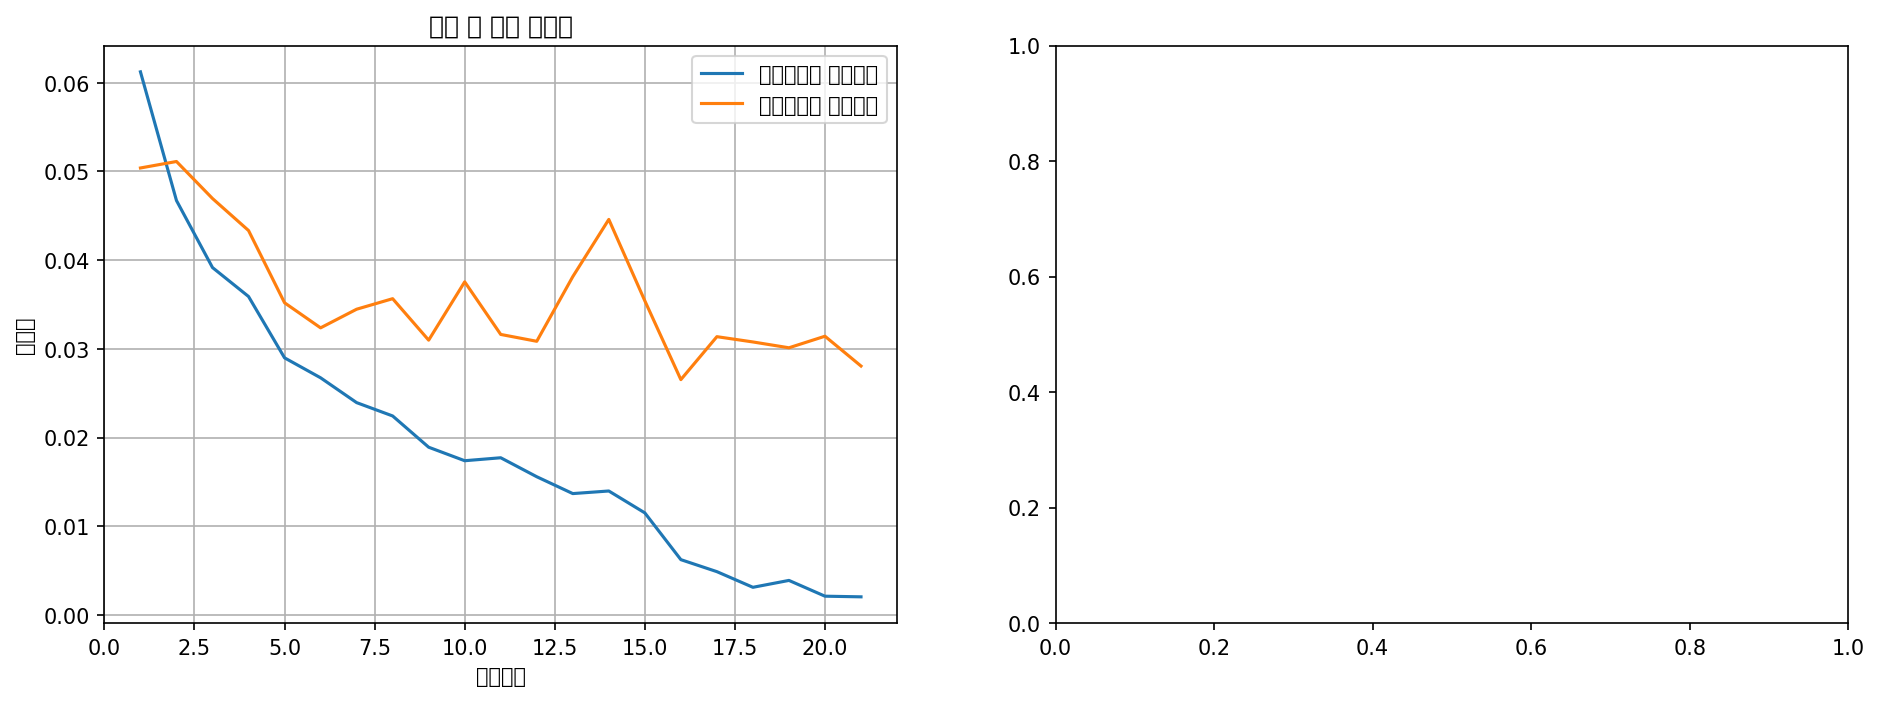

In [21]:
fig, ax = plt.subplots(1,2,figsize=(15,5),dpi = 150)

# 1) 훈련 및 검증데이터 손실함수 시각화
sb.lineplot(x=result_df.index, y='loss',data=result_df,label='훈련데이터 손실함수',ax=ax[0])
sb.lineplot(x=result_df.index,y='val_loss',data=result_df,label='검증데이터 손실함수',ax=ax[0])
ax[0].set_title('훈련 및 검증 손실률')
ax[0].set_xlabel('반복회차')
ax[0].set_ylabel('손실률')
ax[0].grid()
ax[0].legend()
# # 2) 훈련 및 검증 절대오차 그리기
# sns.lineplot(x=result_df.index , y='categorical_crossentropy',data=result_df,label='훈련데이터 acc',ax=ax[1])
# sns.lineplot(x=result_df.index, y='val_categorical_crossentropy',data=result_df,label='검증데이터 acc',ax=ax[1])
# ax[1].set_title('훈련 및 검증 절대오차')
# ax[1].set_xlabel('반복회차')
# ax[1].set_ylabel('정확도')
# ax[1].grid()
# ax[1].legend()

# plt.show()
# plt.close()

In [20]:
result = model.predict(x_train_reshape)
data_count, case_count = result.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
result[0]

1875/1875 [==============================] - 14s 8ms/step
60000개의 검증 데이터가 10개의 경우의 수를 갖는다.


array([2.0336138e-18, 3.2615105e-14, 3.5210688e-18, 5.2327728e-08,
       3.4638538e-23, 1.0000000e+00, 1.6577214e-14, 3.6028761e-19,
       3.0179036e-12, 2.3408740e-16], dtype=float32)

### 가장 큰 확률값의 인덱스를 별도 리스트로 추출


In [22]:
arg_result= np.argmax(result,axis=1)


### 데이터 비교

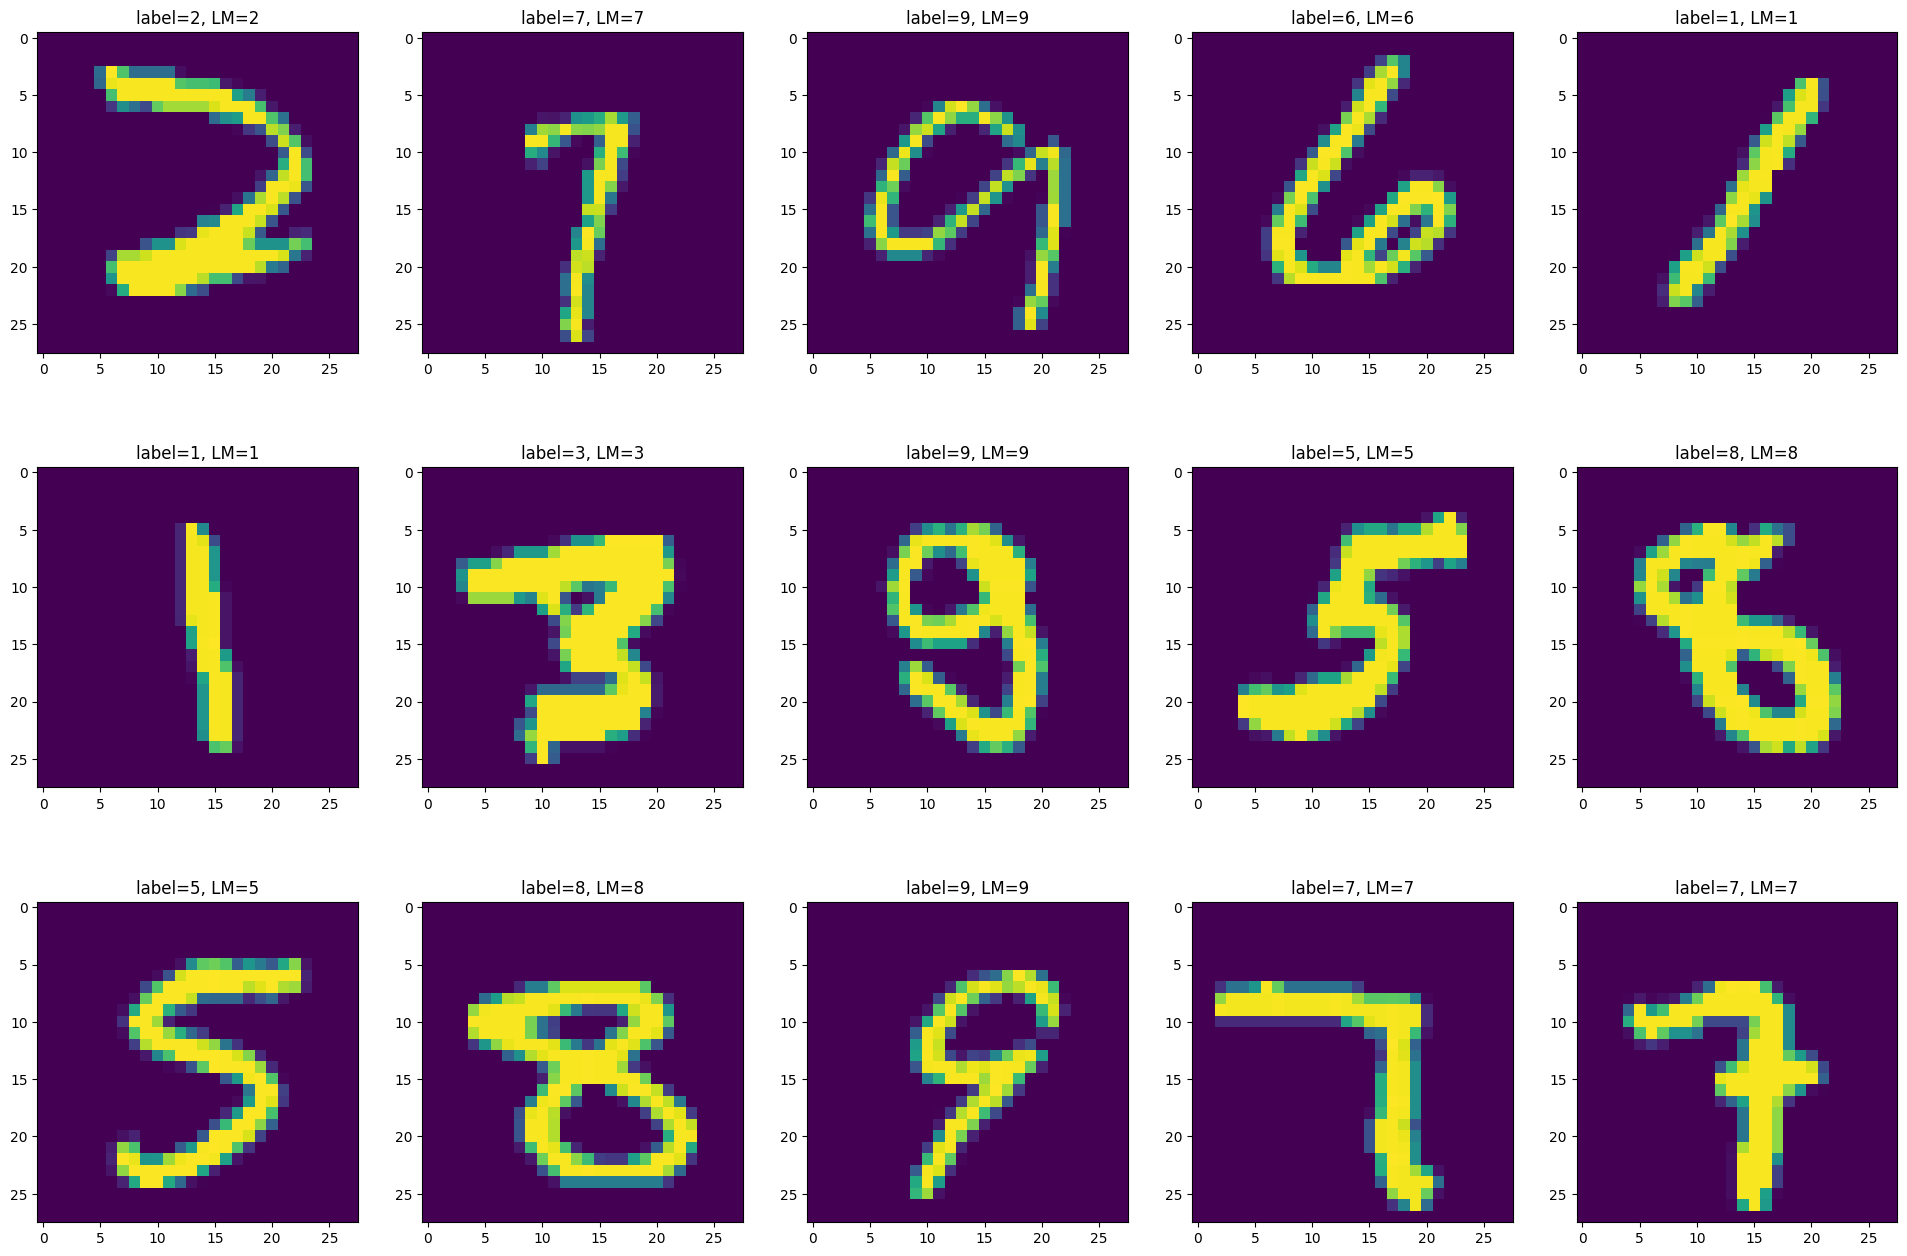

In [25]:
row =3 
col = 5
fig,ax =plt.subplots(row,col,figsize=((col+1)*4,(row+1)*4),dpi = 100)
size = row * col
length=len(y_train)
for i in range(0,size):
    k = np.random.randint(length)
    train = x_train[k]
    label = y_train[k]
    ax[i//col][i%col].imshow(train)
    ax[i//col][i%col].set_title("label=%d, LM=%d" % (label, arg_result[k]))

plt.show()
plt.close()

In [26]:
cm = confusion_matrix(y_train, arg_result)
cmdf2 = pd.DataFrame(cm, columns=list(map(lambda x: "실제값(%d)" % x, range(10))), index=list(map(lambda x: "예측값(%d)" % x, range(10))))
cmdf2

,실제값(0),실제값(1),실제값(2),실제값(3),실제값(4),실제값(5),실제값(6),실제값(7),실제값(8),실제값(9)
예측값(0),5923,0,0,0,0,0,0,0,0,0
예측값(1),0,6742,0,0,0,0,0,0,0,0
예측값(2),0,0,5958,0,0,0,0,0,0,0
예측값(3),0,0,0,6130,0,0,0,0,0,1
예측값(4),0,0,0,0,5842,0,0,0,0,0
예측값(5),0,0,0,0,0,5421,0,0,0,0
예측값(6),0,0,0,0,0,0,5918,0,0,0
예측값(7),0,0,0,0,0,0,0,6265,0,0
예측값(8),0,1,0,0,0,0,0,0,5850,0
예측값(9),0,0,0,0,0,0,0,1,0,5948


plt.figure(figsize=(15, 10))
sb.heatmap(cmdf2, annot = True, fmt = 'd', cmap = 'Blues')
plt.xlabel('결과값')
plt.ylabel('예측값')
plt.show()
plt.close()